In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets accelerate scikit-learn matplotlib seaborn

In [ ]:

import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [ ]:

DATA_PATH = "/content/drive/MyDrive/all-data.csv"

try:
    df = pd.read_csv(DATA_PATH, encoding="latin1")
    if df.shape[1] == 1:
        raise ValueError
    df.columns = ["raw_label", "text"]
except:
    df = pd.read_csv(DATA_PATH, sep=";", header=None, encoding="latin1")
    df.columns = ["raw_label", "text"]

label_map = {
    "negative": "Potential Risk",
    "neutral": "Control",
    "positive": "Internal Control"
}

df = df[df["raw_label"].isin(label_map)]
df["label"] = df["raw_label"].map(label_map)
df["text"] = df["text"].astype(str)

print("Dataset Distribution:")
print(df["label"].value_counts())
df.head()


Dataset Distribution:
label
Control             2878
Internal Control    1363
Potential Risk       604
Name: count, dtype: int64


,raw_label,text,label
0,neutral,Technopolis plans to develop in stages an area...,Control
1,negative,The international electronic industry company ...,Potential Risk
2,positive,With the new production plant the company woul...,Internal Control
3,positive,According to the company 's updated strategy f...,Internal Control
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,Internal Control


In [ ]:

label2id = {
    "Potential Risk": 0,
    "Control": 1,
    "Internal Control": 2
}
id2label = {v:k for k,v in label2id.items()}

df["label_id"] = df["label"].map(label2id)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label_id"],
    test_size=0.2,
    stratify=df["label_id"],
    random_state=SEED
)

print("Training samples:", len(X_train))
print("Testing samples :", len(X_test))


Training samples: 3876
Testing samples : 969


In [ ]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=200
    )

train_ds = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_ds = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch")
test_ds.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

In [ ]:

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert_all_data_model",

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    report_to="none",
    seed=42
)

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-1556674993.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.039600,0.988904,0.861713,0.865649,0.861713,0.857832
2,0.028500,0.801938,0.860681,0.861900,0.860681,0.861134
3,0.025000,0.985659,0.871001,0.874561,0.871001,0.872015
4,0.015900,0.988076,0.875129,0.875268,0.875129,0.872968
5,0.027500,0.887598,0.873065,0.872814,0.873065,0.872464
6,0.012500,0.963104,0.867905,0.868972,0.867905,0.868192
7,0.004200,1.037080,0.865841,0.869542,0.865841,0.866733
8,0.005200,0.962442,0.868937,0.869866,0.868937,0.869235
9,0.003200,0.992661,0.874097,0.876626,0.874097,0.874819
10,0.001300,0.982407,0.877193,0.878169,0.877193,0.877475


TrainOutput(global_step=2430, training_loss=0.016276793788980556, metrics={'train_runtime': 1503.1397, 'train_samples_per_second': 25.786, 'train_steps_per_second': 1.617, 'total_flos': 3983701590288000.0, 'train_loss': 0.016276793788980556, 'epoch': 10.0})

In [ ]:
#TF-IDF + SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(max_features=5000)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

svm = LinearSVC()
svm.fit(X_train_vec, y_train)

y_pred_svm = svm.predict(X_test_vec)

svm_acc = accuracy_score(y_test, y_pred_svm)
print("TF-IDF + SVM Accuracy:", svm_acc)

TF-IDF + SVM Accuracy: 0.7739938080495357


In [ ]:
#Embedding + LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_keras = Tokenizer(num_words=10000)
tokenizer_keras.fit_on_texts(X_train)

X_train_seq = tokenizer_keras.texts_to_sequences(X_train)
X_test_seq  = tokenizer_keras.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad  = pad_sequences(X_test_seq, maxlen=200)

model_lstm = Sequential([
    Embedding(10000, 128, input_length=200),
    LSTM(128),
    Dense(3, activation="softmax")
])

model_lstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64, verbose=1)

_, lstm_acc = model_lstm.evaluate(X_test_pad, y_test)
print("Embedding + LSTM Accuracy:", lstm_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.5894 - loss: 0.9426
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7157 - loss: 0.6566
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8719 - loss: 0.3516
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9419 - loss: 0.1843
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9536 - loss: 0.1541
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9747 - loss: 0.0855
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9721 - loss: 0.0972
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9868 - loss: 0.0443
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9886 - loss: 0.0350
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9938 - loss: 0.0250
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7620 - loss: 1.2643
Embedding + LSTM Accuracy: 0.7554179430007935


In [ ]:
#Embedding + GRU
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    Embedding(10000, 128, input_length=200),
    GRU(128),
    Dense(3, activation="softmax")
])

model_gru.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_gru.fit(X_train_pad, y_train, epochs=10, batch_size=64, verbose=1)

_, gru_acc = model_gru.evaluate(X_test_pad, y_test)
print("Embedding + GRU Accuracy:", gru_acc)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5941 - loss: 0.9638
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7256 - loss: 0.6382
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8508 - loss: 0.3724
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9254 - loss: 0.2112
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9602 - loss: 0.1257
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9525 - loss: 0.1336
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9743 - loss: 0.0828
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9813 - loss: 0.0706
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9923 - loss: 0.0292
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9947 - loss: 0.0235
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7413 - loss: 1.3781
Embedding + GRU Accuracy: 0.727554202079773


In [ ]:
bert_acc = accuracy_score(y_test, y_pred)

In [ ]:
results = pd.DataFrame({
    "Model": [
        "TF-IDF + SVM",
        "Embedding + LSTM",
        "Embedding + GRU",
        "BERT (Proposed)"
    ],
    "Accuracy": [
        svm_acc,
        lstm_acc,
        gru_acc,
        bert_acc
    ]
})

results

,Model,Accuracy
0,TF-IDF + SVM,0.773994
1,Embedding + LSTM,0.755418
2,Embedding + GRU,0.727554
3,BERT (Proposed),0.877193


In [ ]:

pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=[id2label[i] for i in range(3)],
    digits=4
))



Classification Report:

                  precision    recall  f1-score   support

  Potential Risk     0.8385    0.9008    0.8685       121
         Control     0.9131    0.8941    0.9035       576
Internal Control     0.8218    0.8309    0.8263       272

        accuracy                         0.8772       969
       macro avg     0.8578    0.8753    0.8661       969
    weighted avg     0.8782    0.8772    0.8775       969



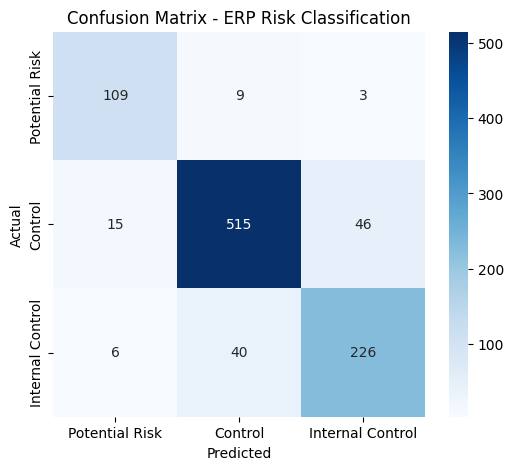

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=id2label.values(),
            yticklabels=id2label.values(),
            cmap="Blues")

plt.title("Confusion Matrix - ERP Risk Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


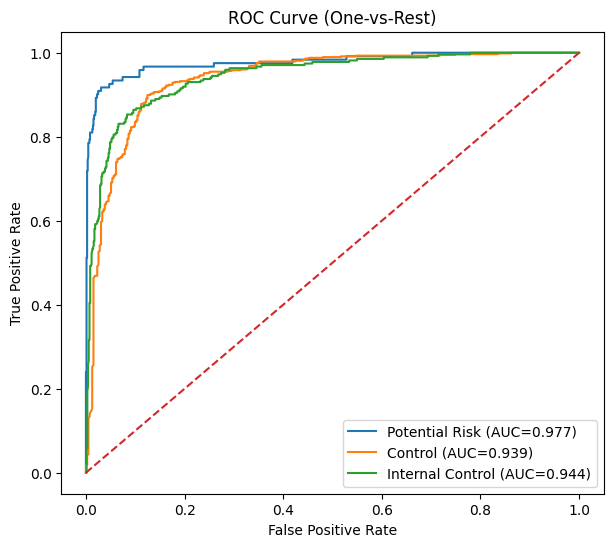

In [ ]:

y_test_bin = label_binarize(y_test, classes=[0,1,2])
y_prob = torch.softmax(torch.tensor(pred.predictions), dim=1).numpy()

plt.figure(figsize=(7,6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


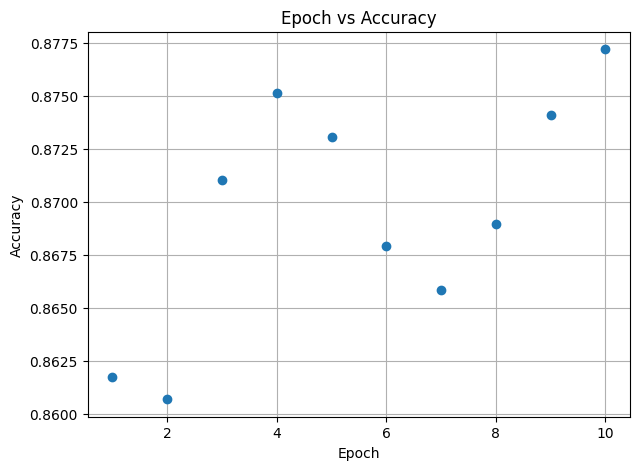

In [ ]:

logs = pd.DataFrame(trainer.state.log_history)
epoch_logs = logs[logs["epoch"].notnull()]

plt.figure(figsize=(7,5))
plt.plot(epoch_logs["epoch"], epoch_logs["eval_accuracy"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.grid(True)
plt.show()


In [ ]:
def validate_erp_text(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=200
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    pred = probs.argmax()

    return {
        "Predicted Category": id2label[pred],
        "Confidence (%)": round(probs[pred] * 100, 2),
        "All Probabilities": {
            id2label[i]: round(probs[i] * 100, 2) for i in range(3)
        }
    }


In [ ]:
#ERP INPUT TESTING

import torch
import numpy as np

def validate_erp_text(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=200
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    pred = int(np.argmax(probs))

    return {
        "Predicted Category": id2label[pred],
        "Confidence (%)": round(float(probs[pred]) * 100, 2),
        "All Probabilities": {
            id2label[i]: round(float(probs[i]) * 100, 2)
            for i in range(len(probs))
        }
    }

# PREDEFINED ERP TEST INPUTS
risk_inputs = [
    "Lack of audit control may lead to financial loss",
    "Unauthorized access can expose confidential data",
    "Delay in supplier delivery may affect operations",
    "Absence of monitoring increases operational risk",
    "Improper approval process may cause compliance failure",
    "Cybercrime is good for the country",
    "Crimerate is increasing and it is actually a good sign"
]

control_inputs = [
    "Approval process is followed for all transactions",
    "Regular monitoring is performed by the supervisor",
    "Access is reviewed periodically",
    "Audit procedures are documented",
    "Control measures are implemented",
    "I have committed a major crime and i have no regrets",
    "I have contacts with the many illegal people."
]

internal_control_inputs = [
    "Strong internal control framework is implemented",
    "Automated validation ensures data accuracy",
    "Access control policies are strictly enforced",
    "System automatically prevents unauthorized actions",
    "Well defined internal audit mechanism exists",
    "I bought 10K bit coin and now price of them have rocketed now i am rich",
    "I was blessed by heaven and god is always with me",
    "I got hit by a car and i was greatly injured",
    "I am going to commit a suicide"
]

test_cases = {
    "Potential Risk": risk_inputs,
    "Control": control_inputs,
    "Internal Control": internal_control_inputs
}

# RUN ALL TEST CASES
for expected_class, texts in test_cases.items():
    print("\n===================================")
    print("EXPECTED CLASS:", expected_class)
    print("===================================")

    for text in texts:
        result = validate_erp_text(text)
        print("\nInput :", text)
        print("Output:", result)


EXPECTED CLASS: Potential Risk

Input : Lack of audit control may lead to financial loss
Output: {'Predicted Category': 'Potential Risk', 'Confidence (%)': 99.99, 'All Probabilities': {'Potential Risk': 99.99, 'Control': 0.0, 'Internal Control': 0.0}}

Input : Unauthorized access can expose confidential data
Output: {'Predicted Category': 'Control', 'Confidence (%)': 99.95, 'All Probabilities': {'Potential Risk': 0.05, 'Control': 99.95, 'Internal Control': 0.0}}

Input : Delay in supplier delivery may affect operations
Output: {'Predicted Category': 'Potential Risk', 'Confidence (%)': 100.0, 'All Probabilities': {'Potential Risk': 100.0, 'Control': 0.0, 'Internal Control': 0.0}}

Input : Absence of monitoring increases operational risk
Output: {'Predicted Category': 'Potential Risk', 'Confidence (%)': 99.99, 'All Probabilities': {'Potential Risk': 99.99, 'Control': 0.0, 'Internal Control': 0.0}}

Input : Improper approval process may cause compliance failure
Output: {'Predicted Catego

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Total dataset
total_samples = len(df)

# Train–Test split (80–20)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"],
    df["label_id"],
    test_size=0.20,
    stratify=df["label_id"],
    random_state=42
)

# Validation split from training (10% of total → 12.5% of train)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.125,
    stratify=train_labels,
    random_state=42
)

# Counts
train_count = len(train_texts)
val_count   = len(val_texts)
test_count  = len(test_texts)

# DISTRIBUTION TABLE
distribution_table = pd.DataFrame({
    "Dataset Split": ["Training", "Validation", "Testing", "Total"],
    "Number of Samples": [
        train_count,
        val_count,
        test_count,
        total_samples
    ],
    "Percentage (%)": [
        round(train_count / total_samples * 100, 2),
        round(val_count / total_samples * 100, 2),
        round(test_count / total_samples * 100, 2),
        100.0
    ]
})

distribution_table


,Dataset Split,Number of Samples,Percentage (%)
0,Training,3391,69.99
1,Validation,485,10.01
2,Testing,969,20.00
3,Total,4845,100.00


In [ ]:
class_distribution = pd.DataFrame({
    "Class": [id2label[i] for i in sorted(id2label)],
    "Total Samples": df["label_id"].value_counts().sort_index().values,
    "Training": pd.Series(train_labels).value_counts().sort_index().values,
    "Validation": pd.Series(val_labels).value_counts().sort_index().values,
    "Testing": pd.Series(test_labels).value_counts().sort_index().values
})

class_distribution

,Class,Total Samples,Training,Validation,Testing
0,Potential Risk,604,423,60,121
1,Control,2878,2014,288,576
2,Internal Control,1363,954,137,272


In [ ]:
%cd "content/drive/MyDrive/Colab Notebooks"

[Errno 2] No such file or directory: 'content/drive/MyDrive/Colab Notebooks'
/content


In [2]:
import nbformat

nb = nbformat.read("/content/drive/MyDrive/ERP_BERT_all_data_FINAL.ipynb", as_version=4)

# Remove widget metadata
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

nbformat.write(nb, "/content/drive/MyDrive/Fixed_ERP_BERT_all_data_FINAL.ipynb")


FileNotFoundError: [Errno 2] No such file or directory: 'ERP_BERT_all_data_FINAL.ipynb'